In [26]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
# Load the JSON files containing the minizinc challenge results for both configurations

with open('../mznc2025_probs/problems_with_descriptions.json', 'r') as f1:
    mznOnlyResults = json.load(f1)

with open('./data/top3_tables.json', 'r') as f2:
    allSolversResults = json.load(f2)

# Load the JSON files containing LLMs results for every configuration

with open('./data/LLMsuggestions_minizinc_commented.json', 'r') as f3:
    LLMResults_mzn_commented = json.load(f3)

with open('./data/LLMsuggestions_minizinc_uncommented.json', 'r') as f4:
    LLMResults_mzn_uncommented = json.load(f4)

with open('./data/LLMsuggestions_all_commented.json', 'r') as f5:
    LLMResults_all_commented = json.load(f5)

with open('./data/LLMsuggestions_all_uncommented.json', 'r') as f6:
    LLMResults_all_uncommented = json.load(f6)

In [28]:
# Flatten problems_with_descriptions.json to a DataFrame
mznTop3_df = pd.DataFrame.from_dict(mznOnlyResults, orient='index')
mznTop3_df.index.name = 'problem_name'
# Keep only problem_name and top3_solvers columns
mznTop3_df = mznTop3_df[['top3_solvers']]

# display the DataFrames to verify correctness
mznTop3_df.head()

,top3_solvers
problem_name,
atsp,"[OR-Tools CP-SAT, COIN-BC, Gecode]"
black-hole,"[Chuffed, OR-Tools CP-SAT, Gecode]"
carpet-cutting,"[OR-Tools CP-SAT, Chuffed, HiGHS]"
cgt,"[OR-Tools CP-SAT, Gecode, Chuffed]"
EchoSched,"[OR-Tools CP-SAT, Chuffed, HiGHS]"


In [29]:
# Create a DataFrame from top3_tables.json with problem_name as index and top3_solvers as a list of solver names
def extract_top3_solvers(entry):
    if isinstance(entry, list):
        return [d['solver'] for d in entry if isinstance(d, dict) and 'solver' in d]
    return []

allTop3_df = pd.DataFrame([
    {'problem_name': k, 'top3_solvers': extract_top3_solvers(v)}
    for k, v in allSolversResults.items()
])

allTop3_df = allTop3_df.set_index('problem_name')
allTop3_df.head()

,top3_solvers
problem_name,
EchoSched,"[or-tools_cp-sat-par, gurobi-par, or-tools_cp-..."
atsp,"[gurobi-par, gurobi-free, or-tools_cp-sat-par]"
black-hole (SAT x5),"[chuffed-free, izplus-par, choco-solver__cp_-par]"
carpet-cutting,"[huub-free, or-tools_cp-sat-par, chuffed-free]"
cgt,"[gurobi-par, cplex-par, gurobi-free]"


In [30]:
# Flatten LLM suggestions JSON files to DataFrames
records = []
for provider, models in LLMResults_mzn_commented.items():
    for model, problems in models.items():
        for problem, solvers in problems.items():
            records.append({
                'provider': provider,
                'model': model,
                'problem': problem,
                'solvers': solvers
            })
results_mzn_commented_df = pd.DataFrame(records)

records = []
for provider, models in LLMResults_mzn_uncommented.items():
    for model, problems in models.items():
        for problem, solvers in problems.items():
            records.append({
                'provider': provider,
                'model': model,
                'problem': problem,
                'solvers': solvers
            })
results_mzn_uncommented_df = pd.DataFrame(records)

records = []
for provider, models in LLMResults_all_commented.items():
    for model, problems in models.items():
        for problem, solvers in problems.items():
            records.append({
                'provider': provider,
                'model': model,
                'problem': problem,
                'solvers': solvers
            })
results_all_commented_df = pd.DataFrame(records)

records = []
for provider, models in LLMResults_all_commented.items():
    for model, problems in models.items():
        for problem, solvers in problems.items():
            records.append({
                'provider': provider,
                'model': model,
                'problem': problem,
                'solvers': solvers
            })
results_all_uncommented_df = pd.DataFrame(records)

# Display the first few rows of each DataFrame to verify correctness
results_mzn_commented_df.head(), results_mzn_uncommented_df.head(), results_all_commented_df.head(), results_all_uncommented_df.head()

(  provider             model         problem  \
 0   gemini  gemini-2.5-flash            atsp   
 1   gemini  gemini-2.5-flash      black-hole   
 2   gemini  gemini-2.5-flash  carpet-cutting   
 3   gemini  gemini-2.5-flash             cgt   
 4   gemini  gemini-2.5-flash       EchoSched   
 
                               solvers  
 0   [OR-Tools CP-SAT, Chuffed, HiGHS]  
 1  [Gecode, Chuffed, OR-Tools CP-SAT]  
 2  [OR-Tools CP-SAT, Chuffed, Gecode]  
 3  [Gecode, Chuffed, OR-Tools CP-SAT]  
 4  [OR-Tools CP-SAT, Gecode, Chuffed]  ,
   provider             model         problem  \
 0   gemini  gemini-2.5-flash            atsp   
 1   gemini  gemini-2.5-flash      black-hole   
 2   gemini  gemini-2.5-flash  carpet-cutting   
 3   gemini  gemini-2.5-flash             cgt   
 4   gemini  gemini-2.5-flash       EchoSched   
 
                               solvers  
 0  [OR-Tools CP-SAT, Chuffed, Gecode]  
 1  [Gecode, Chuffed, OR-Tools CP-SAT]  
 2  [OR-Tools CP-SAT, Chuffed, Gecode]

## First Metric
For each model, we count for how many problems it guessed the first solver right

In [31]:
# Define a function to evaluate first solver accuracy

def evaluate_first_solver_accuracy(results_df, original_df, label=""):
    """
    Compare first guessed solver vs. ground-truth top solver for each (provider, model).
    Returns a DataFrame with per-model accuracy results.
    """

    # Merge model results with ground-truth top solvers
    merged = results_df.merge(
        original_df, left_on='problem', right_index=True, how='left'
    )

    # Extract top solver from ground truth
    merged['top_solver'] = merged['top3_solvers'].apply(
        lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None
    )

    # Extract first guessed solver from model output
    merged['first_guess'] = merged['solvers'].apply(
        lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None
    )

    # Mark correctness
    merged['correct_first'] = merged['first_guess'] == merged['top_solver']

    # Group by provider/model and count
    acc = (
        merged.groupby(['provider', 'model'])['correct_first']
        .sum()
        .reset_index()
        .rename(columns={'correct_first': 'num_correct_first_solver'})
    )

    # Count total attempted predictions
    attempts = (
        merged.groupby(['provider', 'model'])['first_guess']
        .count()
        .reset_index()
        .rename(columns={'first_guess': 'num_attempted'})
    )

    # Merge counts + compute accuracy
    acc = acc.merge(attempts, on=['provider', 'model'])
    acc['accuracy_percent'] = (
        100 * acc['num_correct_first_solver'] / acc['num_attempted']
    )

    # Optional: add label (to distinguish commented/uncommented)
    if label:
        acc['dataset'] = label

    return acc.sort_values(['provider', 'accuracy_percent'], ascending=[True, False])


In [32]:
# Evaluate commented mznOnly set
acc_commented = evaluate_first_solver_accuracy(
    results_mzn_commented_df, mznTop3_df, label="mzn_commented"
)

# Evaluate uncommented mznOnly set
acc_uncommented = evaluate_first_solver_accuracy(
    results_mzn_uncommented_df, mznTop3_df, label="mzn_uncommented"
)

# Evaluate commented allSolvers set
acc_all_commented = evaluate_first_solver_accuracy(
    results_all_commented_df, allTop3_df, label="all_commented"
)

# Evaluate uncommented allSolvers set
acc_all_uncommented = evaluate_first_solver_accuracy(
    results_all_uncommented_df, allTop3_df, label="all_uncommented"
)

# Combine all accuracy results into a single DataFrame for comparison
all_accuracies = pd.concat([
    acc_commented,
    acc_uncommented,
    acc_all_commented,
    acc_all_uncommented
])

display(all_accuracies)

,provider,model,num_correct_first_solver,num_attempted,accuracy_percent,dataset
1,gemini,gemini-2.5-flash,11,20,55.0,mzn_commented
3,gemini,gemini-2.5-pro,11,20,55.0,mzn_commented
0,gemini,gemini-2.0-flash,9,20,45.0,mzn_commented
2,gemini,gemini-2.5-flash-lite,9,20,45.0,mzn_commented
15,groq,openai/gpt-oss-20b,8,20,40.0,mzn_commented
...,...,...,...,...,...,...
10,groq,meta-llama/llama-4-scout-17b-16e-instruct,0,20,0.0,all_uncommented
12,groq,moonshotai/kimi-k2-instruct,0,20,0.0,all_uncommented
14,groq,openai/gpt-oss-120b,0,20,0.0,all_uncommented
16,groq,qwen/qwen3-32b,0,20,0.0,all_uncommented


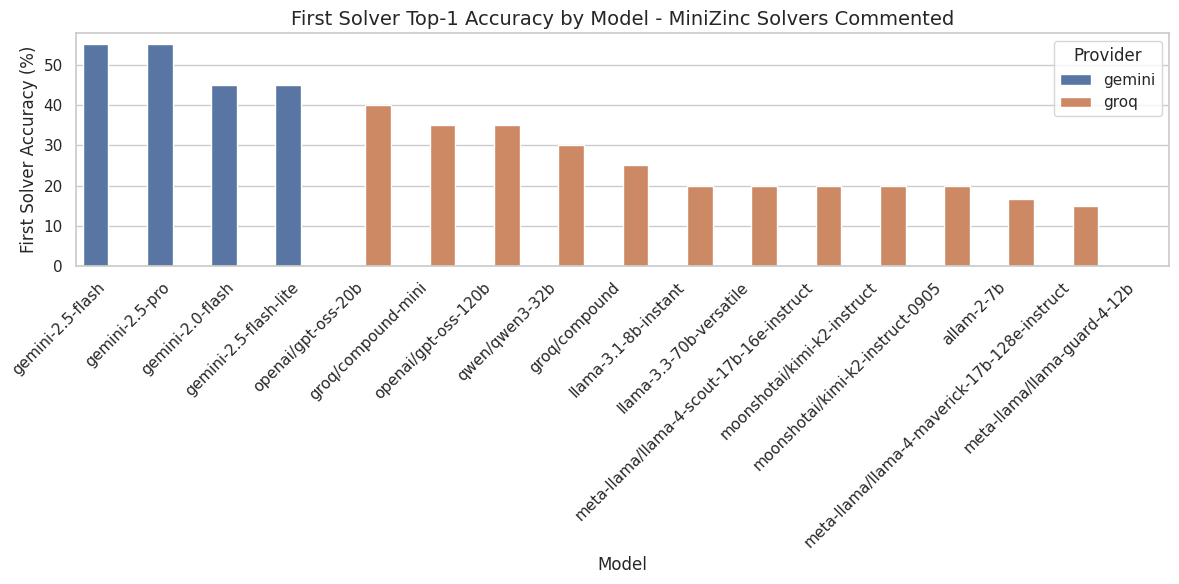

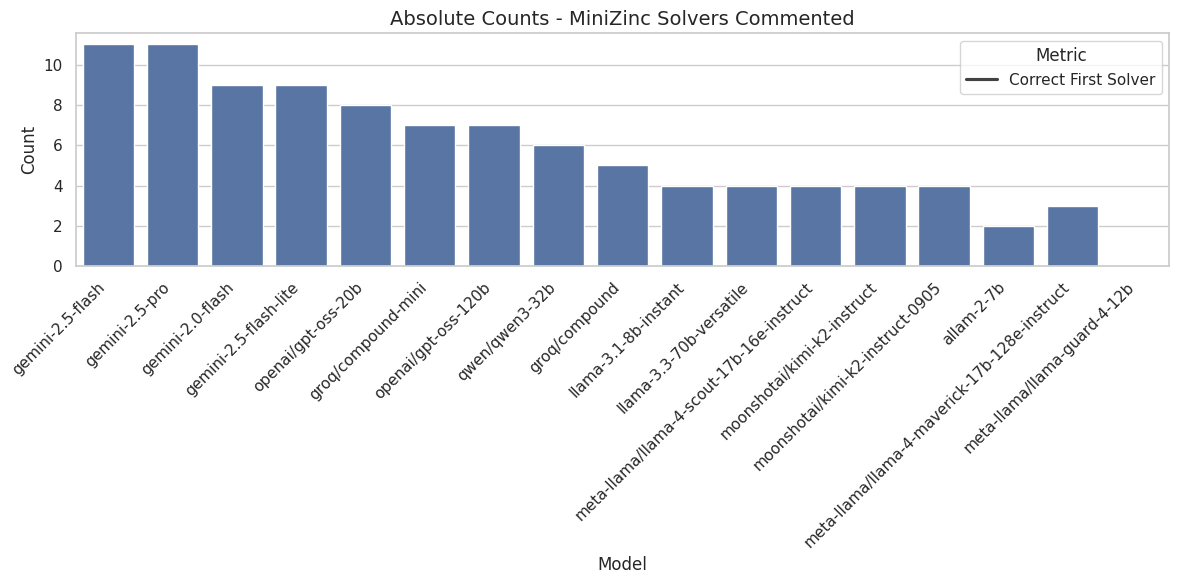

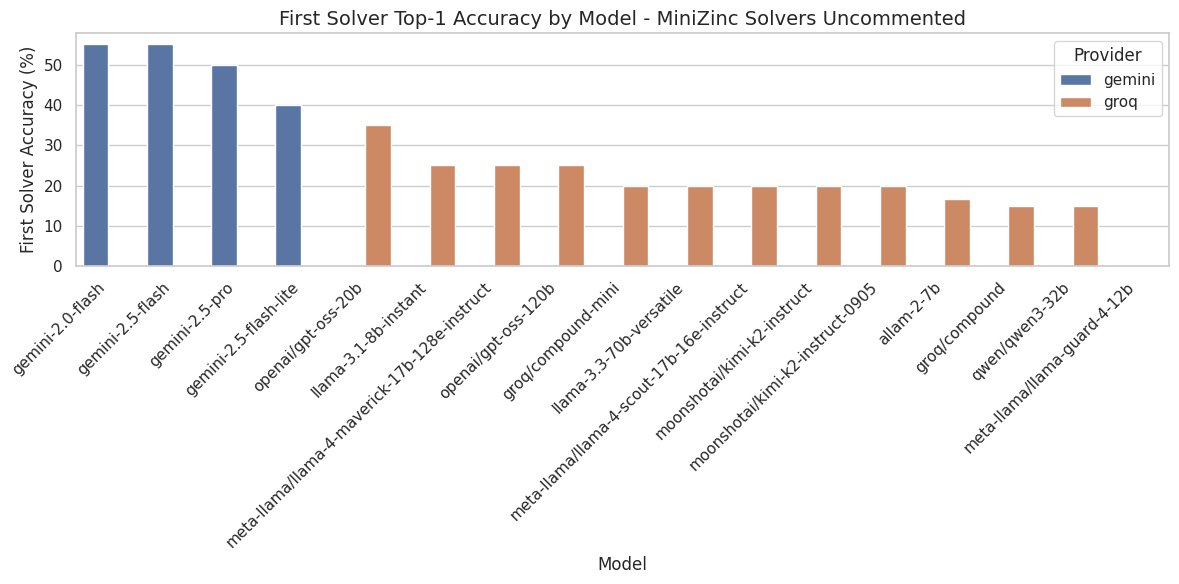

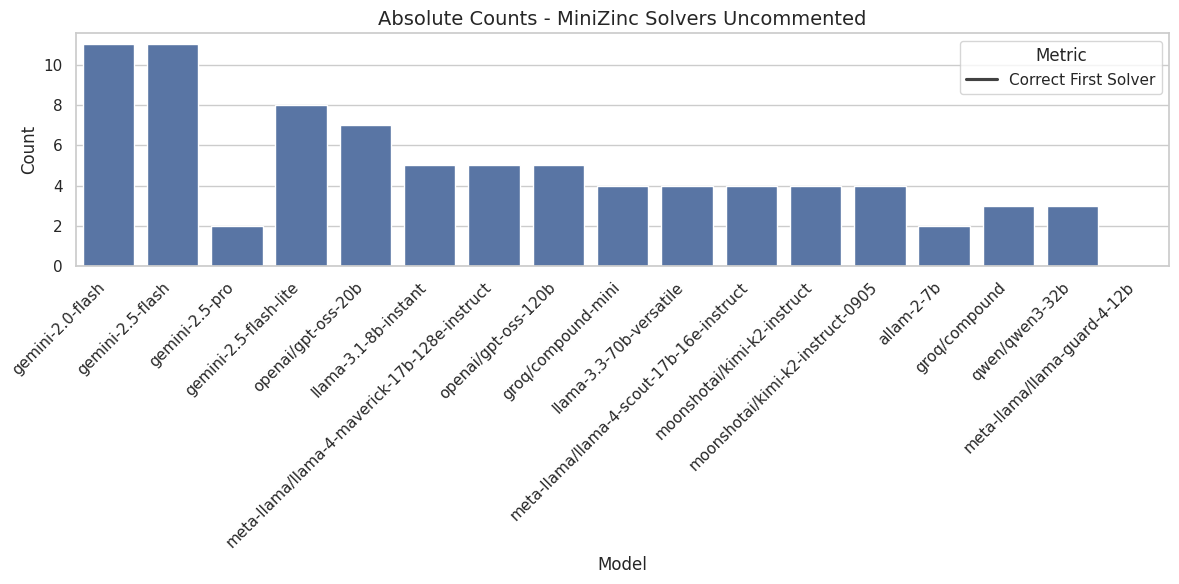

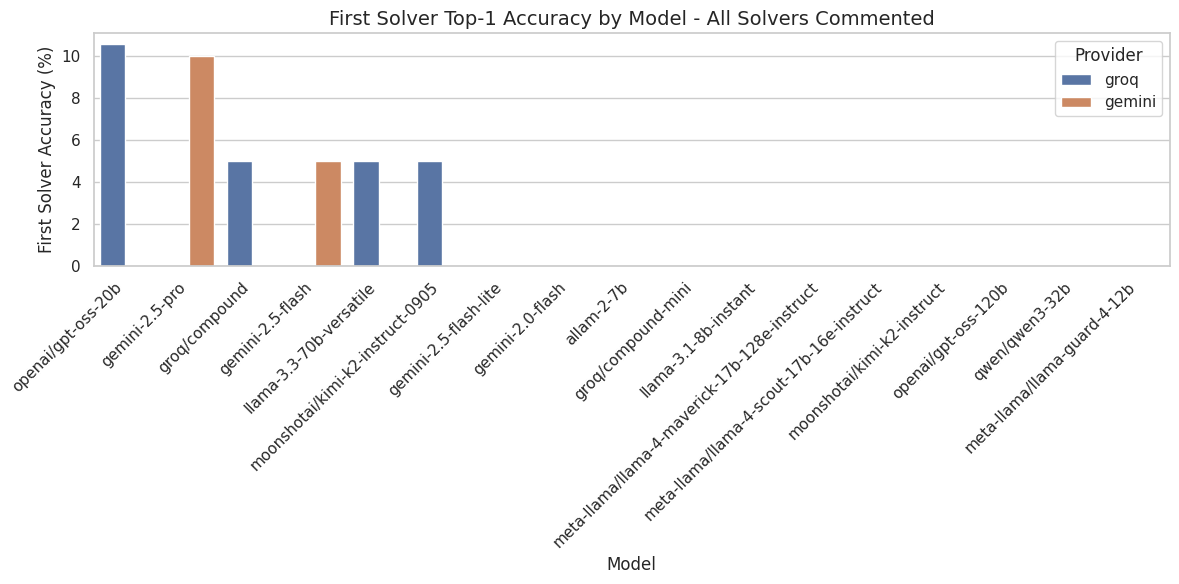

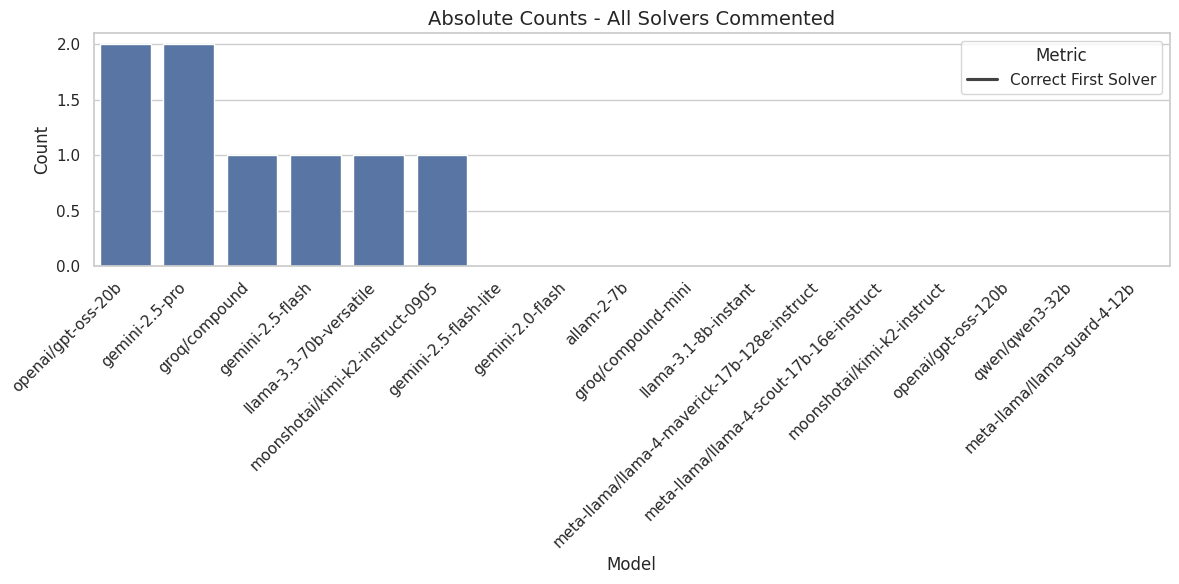

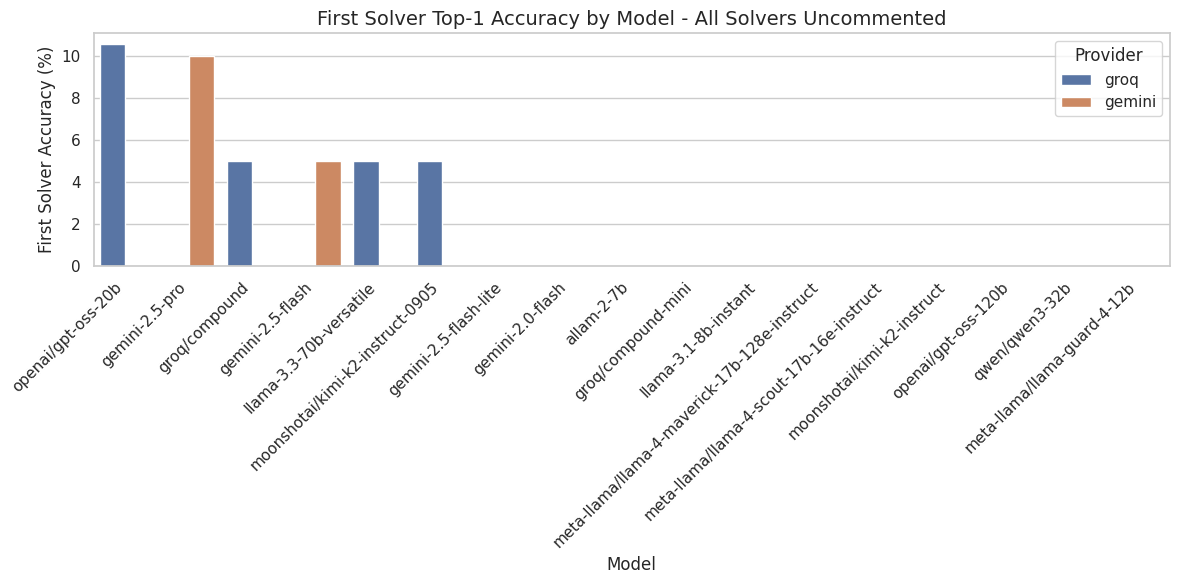

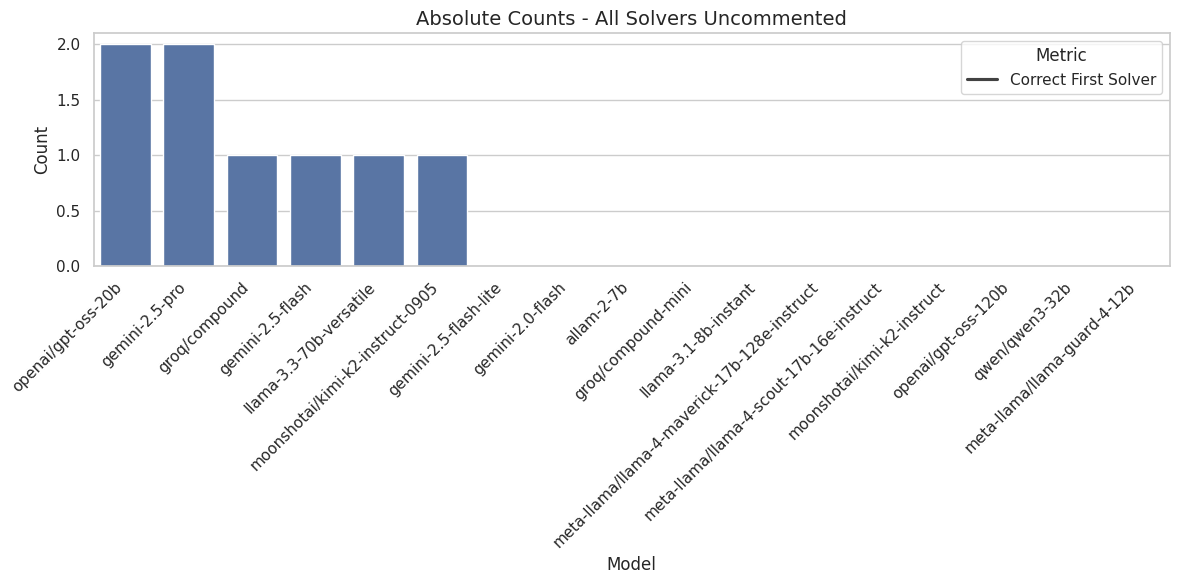

In [ ]:
# Put all accuracy tables and labels in a list for easy iteration
accuracy_tables = [
    ("MiniZinc Solvers Commented", acc_commented),
    ("MiniZinc Solvers Uncommented", acc_uncommented),
    ("All Solvers Commented", acc_all_commented),
    ("All Solvers Uncommented", acc_all_uncommented)
]

sns.set(style="whitegrid")
plt.rcParams.update({'axes.titlesize': 14, 'axes.labelsize': 12})

for title, df in accuracy_tables:
    if df.empty:
        print(f"Skipping {title} — no data available.")
        continue

    plot_df = df.sort_values('accuracy_percent', ascending=False)

    # === 1️ Percentage accuracy barplot ===
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=plot_df,
        x='model',
        y='accuracy_percent',
        hue='provider',
        dodge=True
    )
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('First Solver Accuracy (%)')
    plt.xlabel('Model')
    plt.title(f'First Solver Top-1 Accuracy by Model - {title}')
    plt.legend(title='Provider')
    plt.tight_layout()
    plt.show()

    # === 2️ Absolute counts barplot (correct vs attempted) ===
    # Melt data to plot both counts side by side
    count_df = plot_df.melt(
        id_vars=['provider', 'model'],
        value_vars=['num_correct_first_solver'],
        var_name='Metric',
        value_name='Count'
    )

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=count_df,
        x='model',
        y='Count',
        hue='Metric',
        dodge=True
    )
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count')
    plt.xlabel('Model')
    plt.title(f'Absolute Counts - {title}')
    plt.legend(title='Metric', labels=['Correct First Solver'])
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_33731/2616264766.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(missed_top1_models)


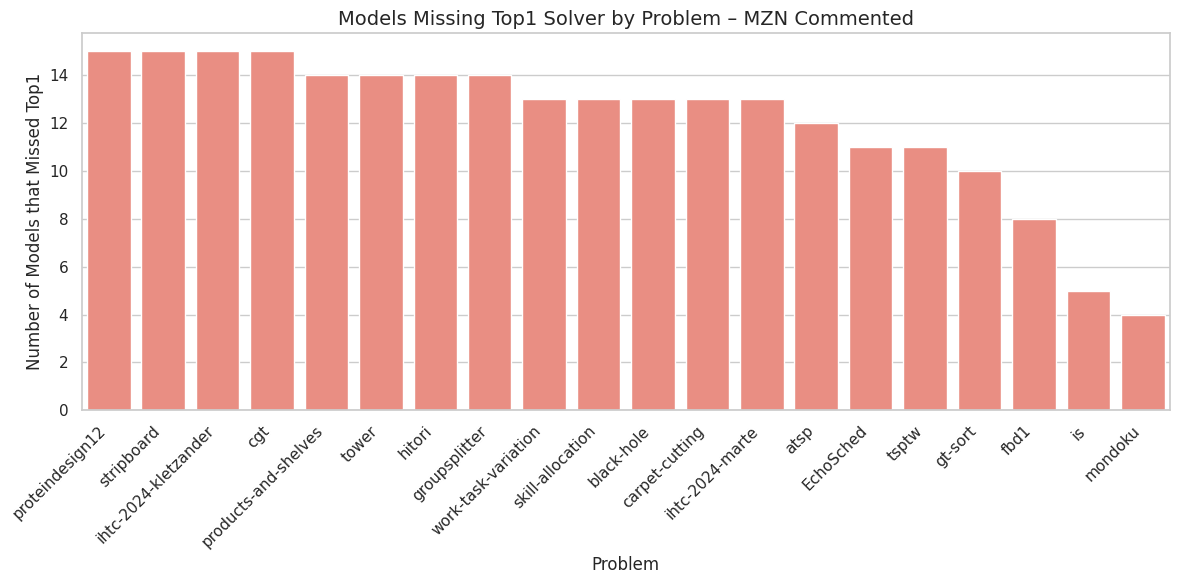

/tmp/ipykernel_33731/2616264766.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(missed_top1_models)


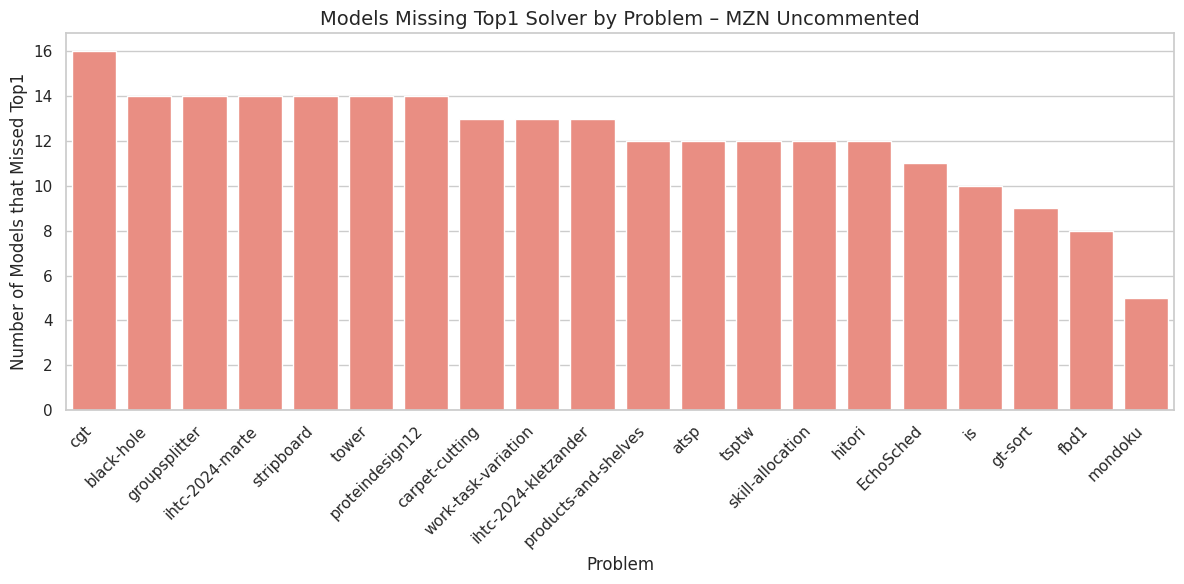

/tmp/ipykernel_33731/2616264766.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(missed_top1_models)


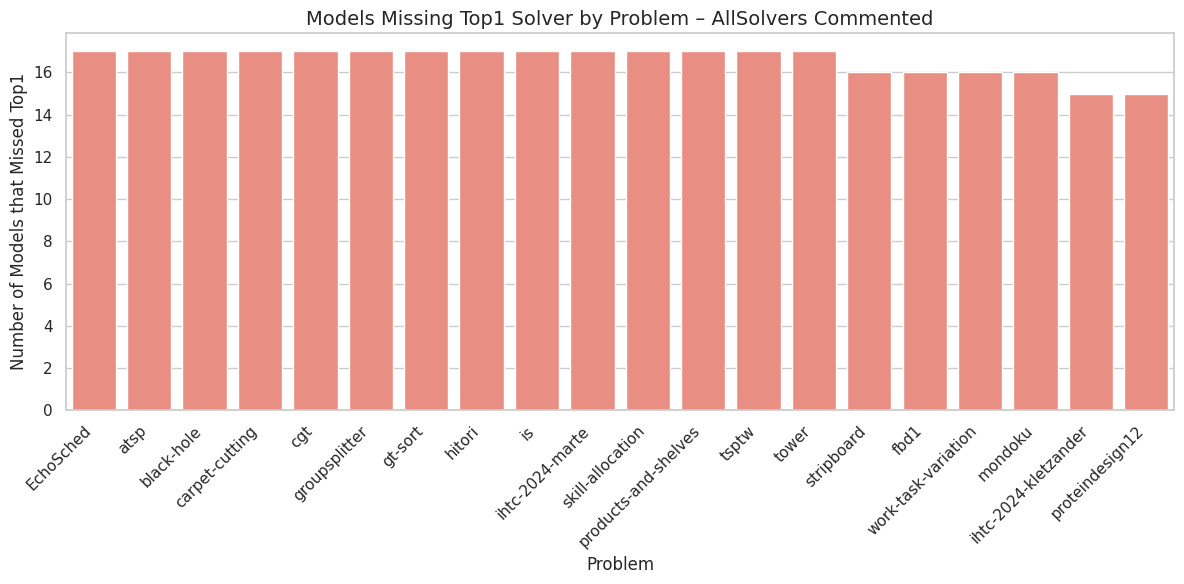

/tmp/ipykernel_33731/2616264766.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(missed_top1_models)


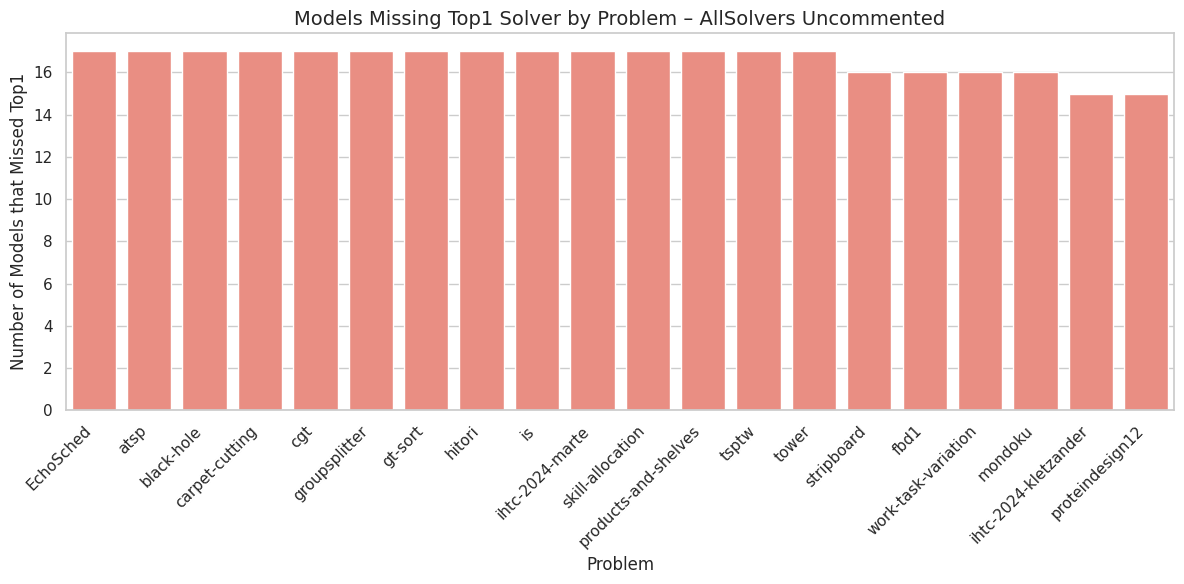

In [38]:
def evaluate_missed_top1(results_df, top3_df, title_label=""):
    """
    For each problem, compute which (provider, model) combinations missed
    the correct top1 solver. Return a DataFrame of misses and plot a histogram.
    """

    # === Recreate results_with_gt like in the accuracy evaluation ===
    merged = results_df.merge(top3_df, left_on='problem', right_index=True, how='left')

    merged['top_solver'] = merged['top3_solvers'].apply(
        lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None
    )
    merged['first_guess'] = merged['solvers'].apply(
        lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None
    )
    merged['correct_first'] = merged['first_guess'] == merged['top_solver']

    # === Compute which models missed each problem ===
    def missed_top1_models(df):
        missed = df[df['correct_first'] == False][['provider', 'model']]
        return list(missed.itertuples(index=False, name=None))

    missed_by_problem = (
        merged.groupby('problem', group_keys=False)
        .apply(missed_top1_models)
        .reset_index()
        .rename(columns={0: 'missed_models'})
    )

    # Keep only problems with at least one miss
    missed_by_problem = missed_by_problem[missed_by_problem['missed_models'].apply(len) > 0]
    missed_by_problem['num_missed'] = missed_by_problem['missed_models'].apply(len)

    # === Plot histogram ===
    plt.figure(figsize=(12, 6))
    missed_by_problem_sorted = missed_by_problem.sort_values('num_missed', ascending=False)
    sns.barplot(
        data=missed_by_problem_sorted,
        x='problem',
        y='num_missed',
        color='salmon'
    )
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Number of Models that Missed Top1')
    plt.xlabel('Problem')
    plt.title(f'Models Missing Top1 Solver by Problem – {title_label}')
    plt.tight_layout()
    plt.show()

    return missed_by_problem


# === Evaluate for each dataset ===
missed_mzn_commented = evaluate_missed_top1(results_mzn_commented_df, mznTop3_df, "MZN Commented")
missed_mzn_uncommented = evaluate_missed_top1(results_mzn_uncommented_df, mznTop3_df, "MZN Uncommented")
missed_all_commented = evaluate_missed_top1(results_all_commented_df, allTop3_df, "AllSolvers Commented")
missed_all_uncommented = evaluate_missed_top1(results_all_uncommented_df, allTop3_df, "AllSolvers Uncommented")

## Second metric
For each model, we count how many solvers out of the top 3 did it guess in thirds

In [39]:
def evaluate_unordered_overlap(results_df, top3_df, label=""):
    """
    Compute unordered overlap accuracy:
    For each model/problem, count how many guessed solvers are in the top3 (unordered),
    give 1/3 point for each correct solver, then average across problems.
    """
    merged = results_df.merge(top3_df, left_on='problem', right_index=True, how='left')

    def count_overlap(guessed, top3):
        if not isinstance(guessed, list) or not isinstance(top3, list):
            return 0.0
        return sum(1 for s in guessed if s in top3) / 3.0

    merged['unordered_score'] = merged.apply(
        lambda row: count_overlap(row['solvers'], row['top3_solvers']), axis=1
    )

    # Aggregate by provider/model
    unordered_accuracy = (
        merged.groupby(['provider', 'model'])['unordered_score']
        .sum()
        .reset_index()
        .rename(columns={'unordered_score': 'total_unordered_score'})
    )

    # Count total attempted
    unordered_attempts = (
        merged.groupby(['provider', 'model'])['solvers']
        .count()
        .reset_index()
        .rename(columns={'solvers': 'num_attempted'})
    )

    unordered_accuracy = unordered_accuracy.merge(unordered_attempts, on=['provider', 'model'])
    unordered_accuracy['avg_unordered_score'] = (
        unordered_accuracy['total_unordered_score'] / unordered_accuracy['num_attempted']
    )

    if label:
        unordered_accuracy['dataset'] = label

    return unordered_accuracy.sort_values(['provider', 'avg_unordered_score'], ascending=[True, False])


In [40]:
acc_unordered_mzn_commented = evaluate_unordered_overlap(results_mzn_commented_df, mznTop3_df, "MZN Commented")
acc_unordered_mzn_uncommented = evaluate_unordered_overlap(results_mzn_uncommented_df, mznTop3_df, "MZN Uncommented")
acc_unordered_all_commented = evaluate_unordered_overlap(results_all_commented_df, allTop3_df, "AllSolvers Commented")
acc_unordered_all_uncommented = evaluate_unordered_overlap(results_all_uncommented_df, allTop3_df, "AllSolvers Uncommented")

all_unordered_accuracies = pd.concat([
    acc_unordered_mzn_commented,
    acc_unordered_mzn_uncommented,
    acc_unordered_all_commented,
    acc_unordered_all_uncommented
])

display(all_unordered_accuracies)

,provider,model,total_unordered_score,num_attempted,avg_unordered_score,dataset
0,gemini,gemini-2.0-flash,18.000000,20,0.900000,MZN Commented
2,gemini,gemini-2.5-flash-lite,18.000000,20,0.900000,MZN Commented
3,gemini,gemini-2.5-pro,18.000000,20,0.900000,MZN Commented
1,gemini,gemini-2.5-flash,17.666667,20,0.883333,MZN Commented
5,groq,groq/compound,18.000000,20,0.900000,MZN Commented
...,...,...,...,...,...,...
8,groq,llama-3.3-70b-versatile,1.333333,20,0.066667,AllSolvers Uncommented
10,groq,meta-llama/llama-4-scout-17b-16e-instruct,1.000000,20,0.050000,AllSolvers Uncommented
9,groq,meta-llama/llama-4-maverick-17b-128e-instruct,0.666667,20,0.033333,AllSolvers Uncommented
4,groq,allam-2-7b,0.333333,20,0.016667,AllSolvers Uncommented


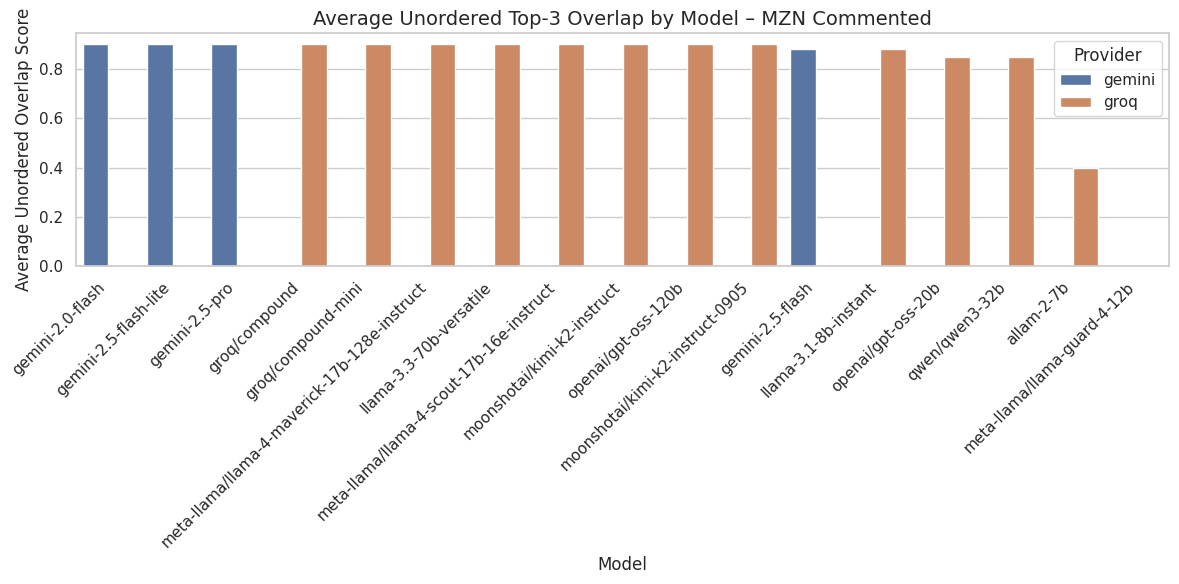

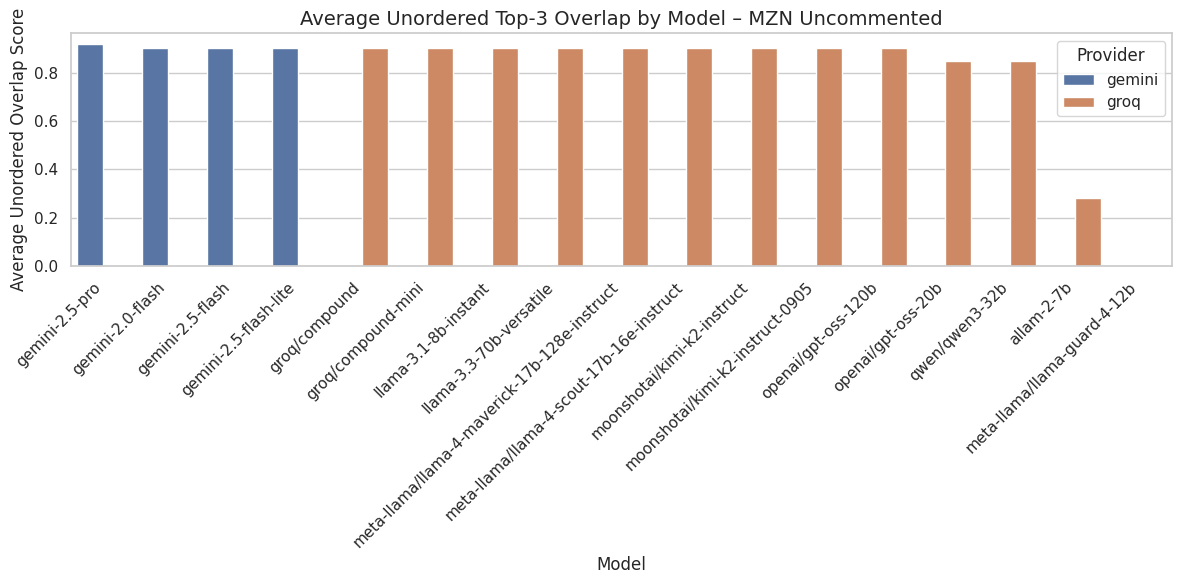

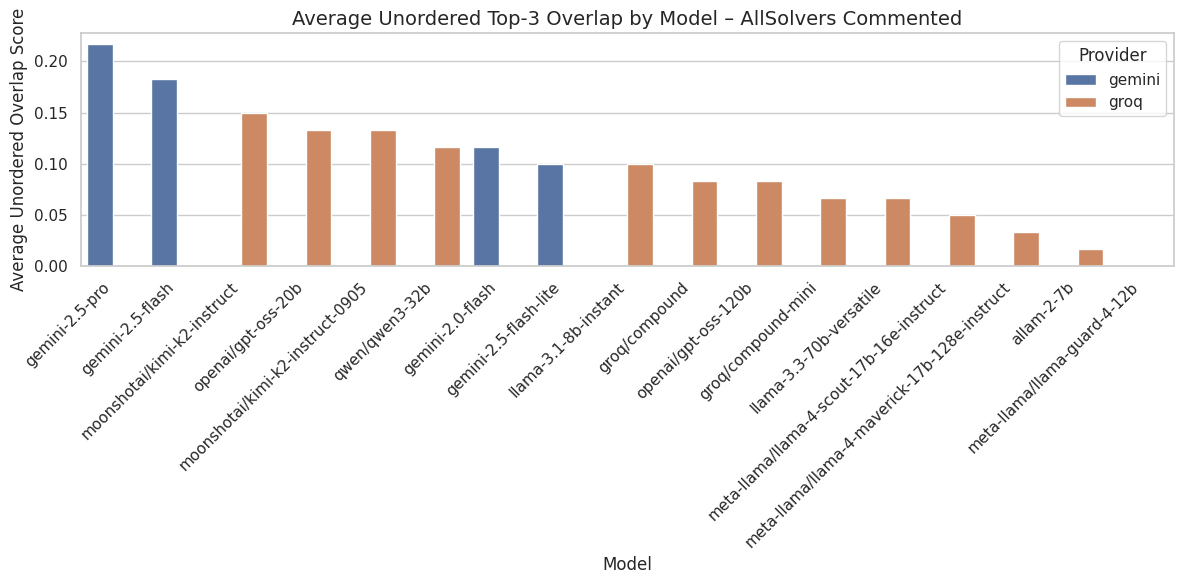

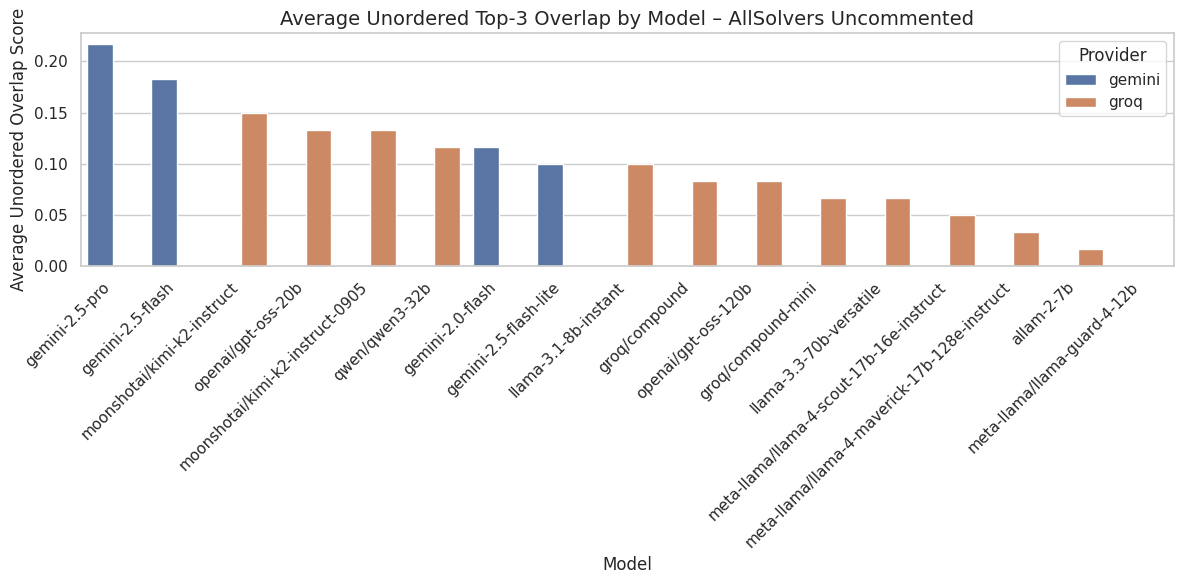

In [43]:
unordered_tables = [
    ("MZN Commented", acc_unordered_mzn_commented),
    ("MZN Uncommented", acc_unordered_mzn_uncommented),
    ("AllSolvers Commented", acc_unordered_all_commented),
    ("AllSolvers Uncommented", acc_unordered_all_uncommented)
]

sns.set(style="whitegrid")
plt.rcParams.update({'axes.titlesize': 14, 'axes.labelsize': 12})

for title, df in unordered_tables:
    if df.empty:
        print(f"Skipping {title} — no data available.")
        continue

    plot_df = df.sort_values('avg_unordered_score', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=plot_df,
        x='model',
        y='avg_unordered_score',
        hue='provider',
        dodge=True
    )
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Average Unordered Overlap Score')
    plt.xlabel('Model')
    plt.title(f'Average Unordered Top-3 Overlap by Model – {title}')
    plt.legend(title='Provider')
    plt.tight_layout()
    plt.show()

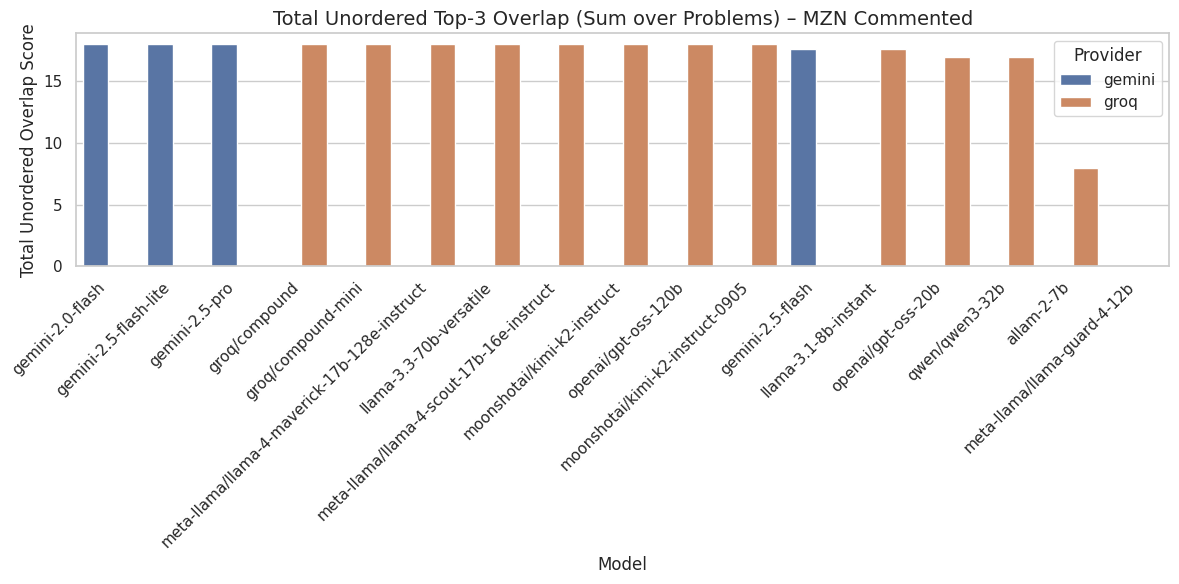

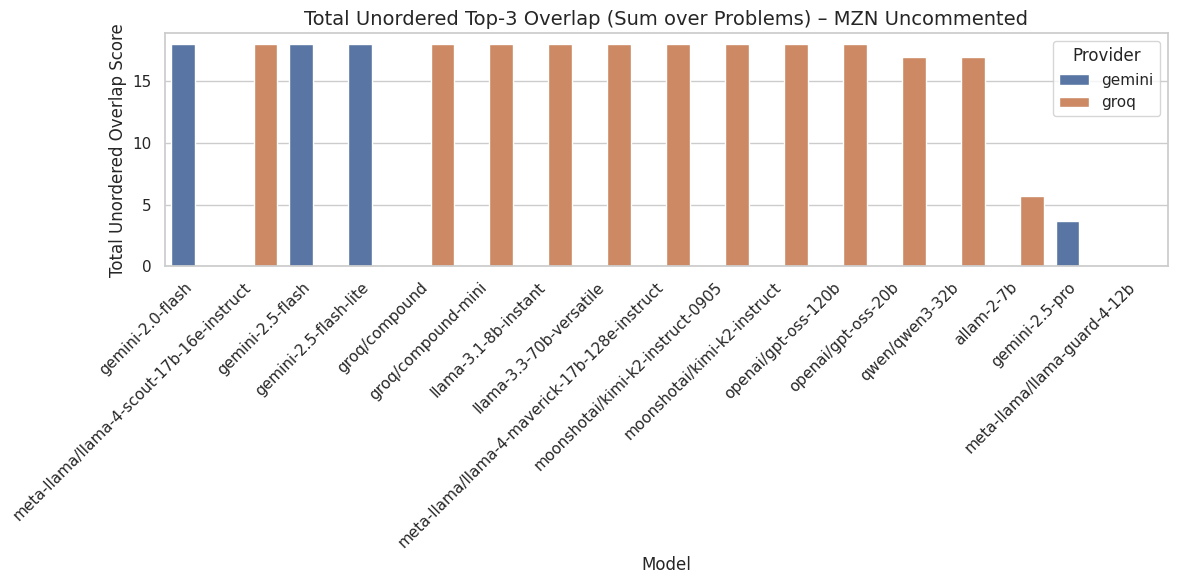

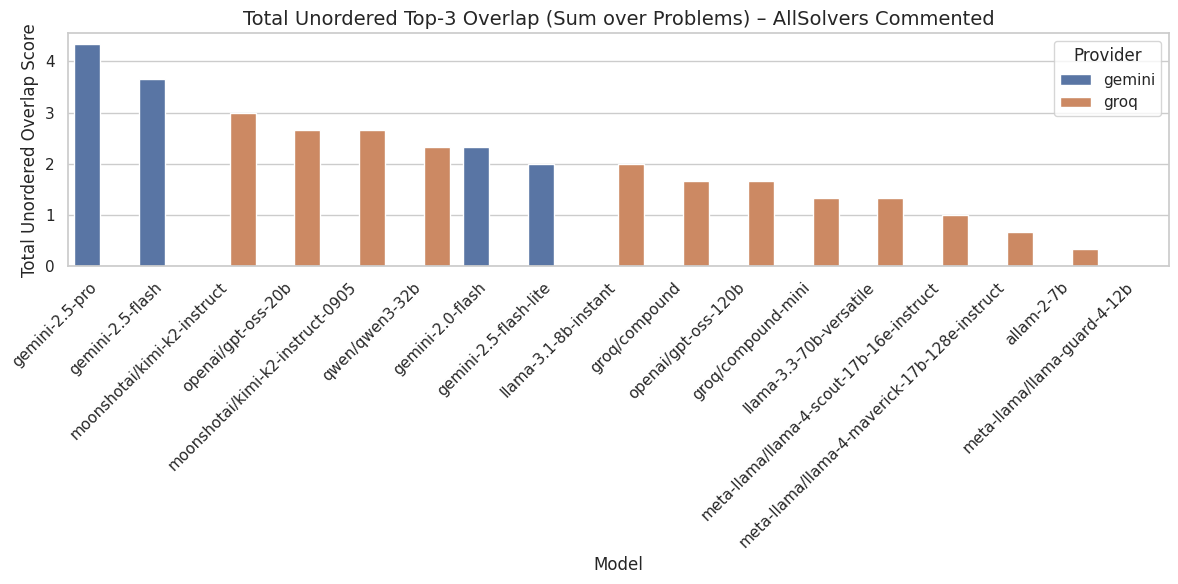

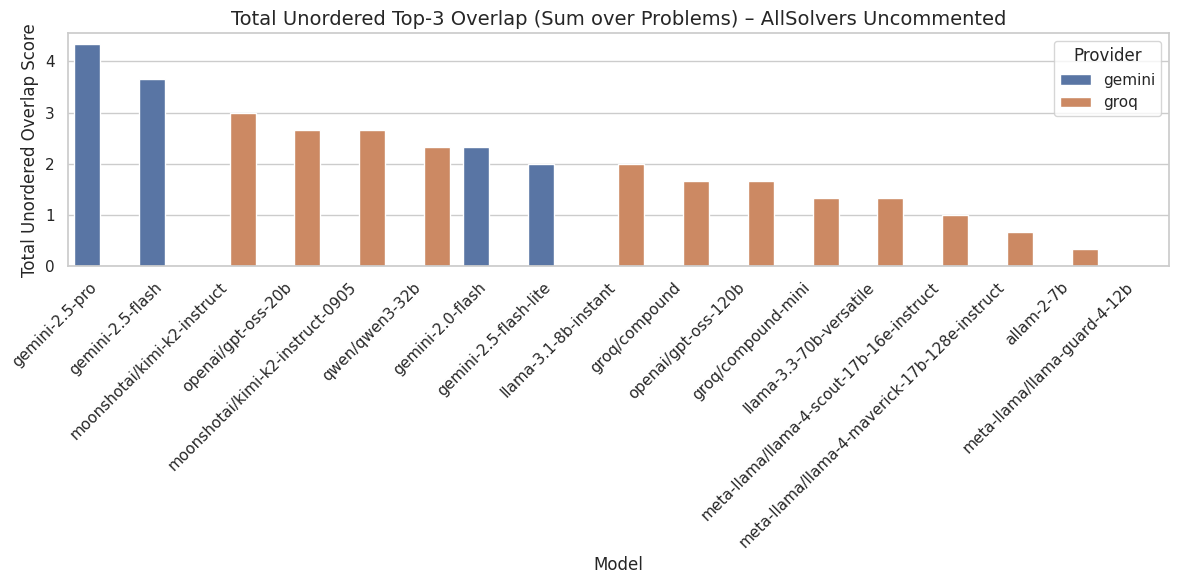

In [44]:
for title, df in unordered_tables:
    if df.empty:
        continue

    plot_df = df.sort_values('total_unordered_score', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=plot_df,
        x='model',
        y='total_unordered_score',
        hue='provider',
        dodge=True
    )
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Total Unordered Overlap Score')
    plt.xlabel('Model')
    plt.title(f'Total Unordered Top-3 Overlap (Sum over Problems) – {title}')
    plt.legend(title='Provider')
    plt.tight_layout()
    plt.show()

### Inverse Evaluation

In [45]:
def evaluate_unordered_inverse(results_df, top3_df, label="", threshold=0.0):
    """
    For each problem, find which models have unordered_score <= threshold.
    Returns a DataFrame of missed models per problem and plots a histogram.
    """
    # === Recreate merged ground truth ===
    merged = results_df.merge(top3_df, left_on='problem', right_index=True, how='left')

    def count_overlap(guessed, top3):
        if not isinstance(guessed, list) or not isinstance(top3, list):
            return 0.0
        return sum(1 for s in guessed if s in top3) / 3.0

    merged['unordered_score'] = merged.apply(
        lambda row: count_overlap(row['solvers'], row['top3_solvers']), axis=1
    )

    # === Group by problem and collect models with score <= threshold ===
    def missed_unordered_models(df):
        missed = df[df['unordered_score'] <= threshold][['provider', 'model']]
        return list(missed.itertuples(index=False, name=None))

    missed_by_problem = (
        merged.groupby('problem', group_keys=False)
        .apply(missed_unordered_models)
        .reset_index()
        .rename(columns={0: 'missed_models'})
    )

    # Keep only problems with at least one miss
    missed_by_problem = missed_by_problem[missed_by_problem['missed_models'].apply(len) > 0]
    missed_by_problem['num_missed'] = missed_by_problem['missed_models'].apply(len)

    # === Plot ===
    plt.figure(figsize=(12, 6))
    missed_by_problem_sorted = missed_by_problem.sort_values('num_missed', ascending=False)
    sns.barplot(
        data=missed_by_problem_sorted,
        x='problem',
        y='num_missed',
        color='skyblue'
    )
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Number of Models with Low Unordered Score')
    plt.xlabel('Problem')
    plt.title(f'Models with Unordered Score ≤ {threshold:.2f} – {label}')
    plt.tight_layout()
    plt.show()

    return missed_by_problem

/tmp/ipykernel_33731/617818590.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(missed_unordered_models)


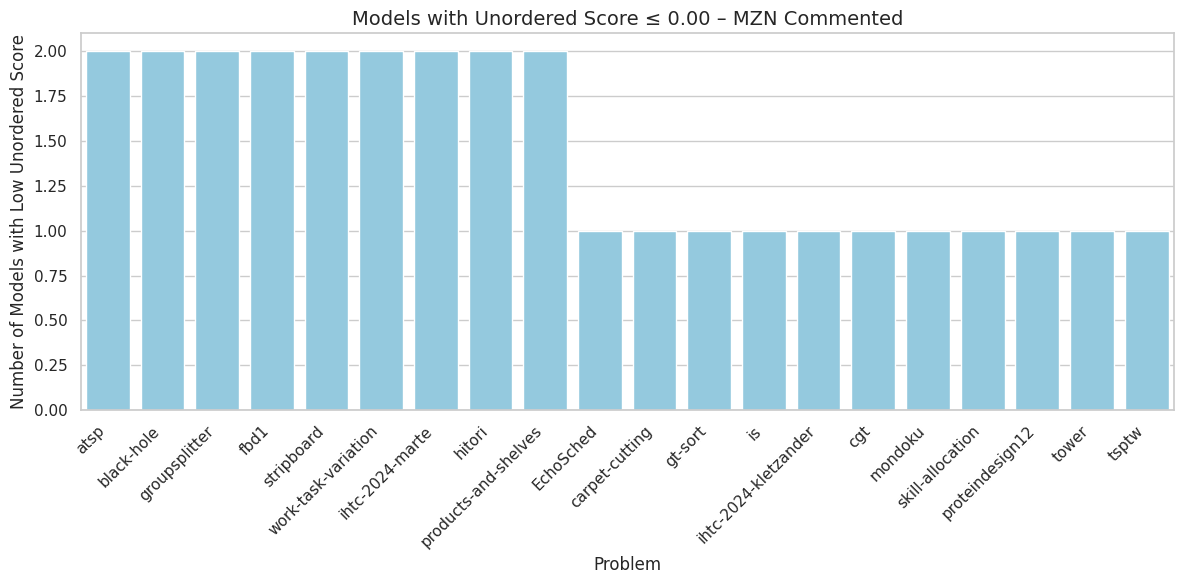

/tmp/ipykernel_33731/617818590.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(missed_unordered_models)


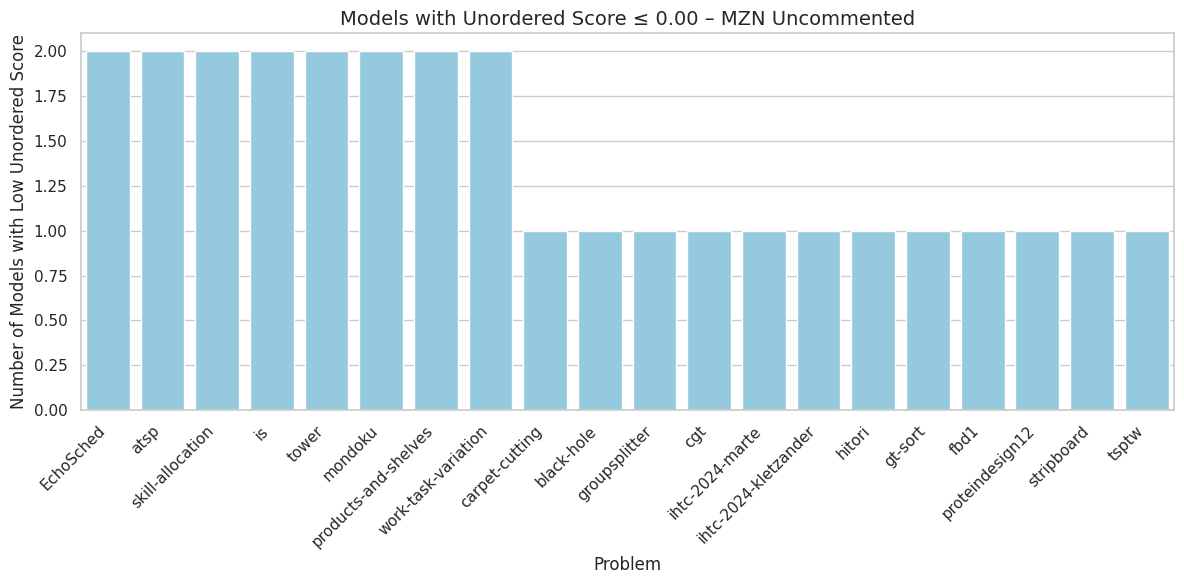

/tmp/ipykernel_33731/617818590.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(missed_unordered_models)


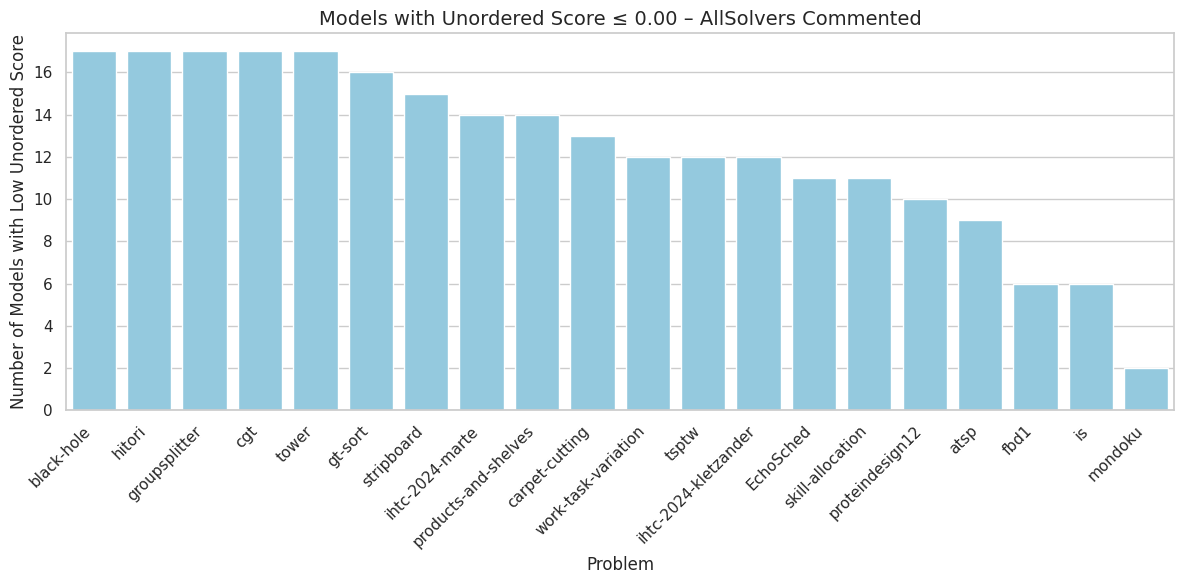

/tmp/ipykernel_33731/617818590.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(missed_unordered_models)


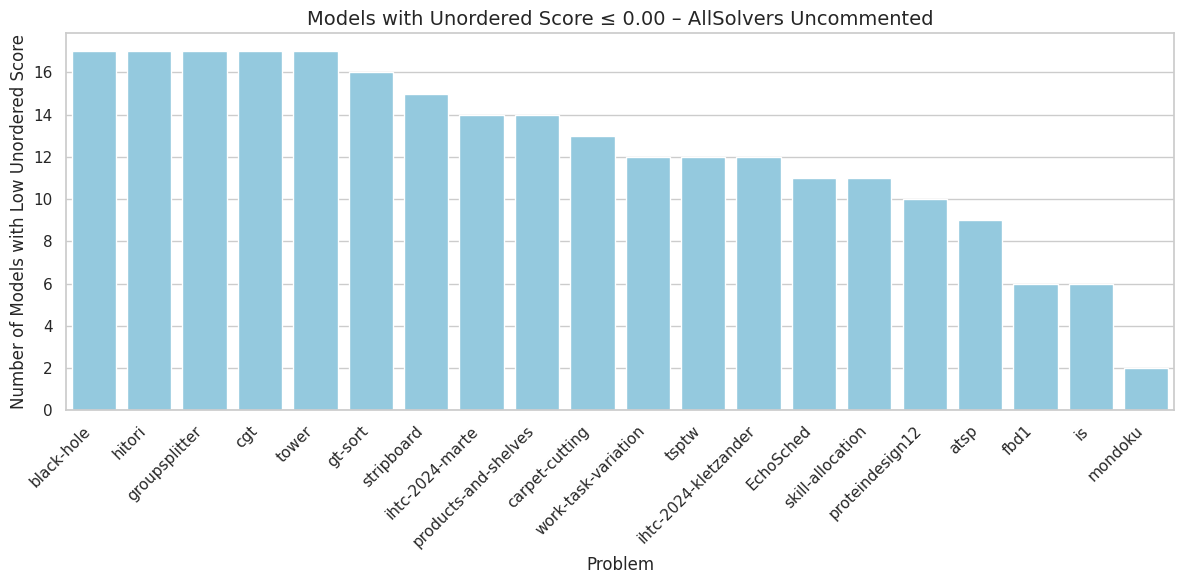

In [46]:
# Default threshold = 0.0 means "missed all top3"
missed_unordered_mzn_commented = evaluate_unordered_inverse(
    results_mzn_commented_df, mznTop3_df, "MZN Commented", threshold=0.0
)
missed_unordered_mzn_uncommented = evaluate_unordered_inverse(
    results_mzn_uncommented_df, mznTop3_df, "MZN Uncommented", threshold=0.0
)
missed_unordered_all_commented = evaluate_unordered_inverse(
    results_all_commented_df, allTop3_df, "AllSolvers Commented", threshold=0.0
)
missed_unordered_all_uncommented = evaluate_unordered_inverse(
    results_all_uncommented_df, allTop3_df, "AllSolvers Uncommented", threshold=0.0
)

## ChatGPT 5.0 Suggestions
### The problem with worst results got tested with ChatGPT 5.0 (Uncommented versions on all solvers):
- blackhole: [chuffed-fd, gecode-fd, or-tools_cp-sat-fd] 	0/3
- cgt: [chuffed-fd, gecode-fd, or-tools_cp-sat-fd] 		0/3
- groupsplitter: [chuffed-fd, gecode-fd, or-tools_cp-sat-fd]	0/3
- hitori: [chuffed-fd, gecode-fd, sicstus_prolog-fd] 		0/3
- tower: [chuffed-fd, gecode-fd, or-tools_cp-sat-fd] 		0/3

### Sadly ChatGPT 5.0 never guessed correctly, reaching 0/15 overlaps.